In [ ]:
import pandas as pd
import numpy as np

Read the train data from google drive

In [ ]:
df_train = pd.read_csv("/content/task_1_information_extraction_train.tsv",header=0, sep='\t' )
# df_train=df_train.iloc[:100,:]
df_train.head()

,NOTES,EVENT_DATE,SOURCE,FATALITIES,EVENT_TYPE,SUB_EVENT_TYPE,ACTOR1,INTER1,ACTOR2,INTER2,INTERACTION,LOCATION
0,Three people were killed while 27 others injur...,29-August-2012,Statesman (Pakistan),3,Explosions/Remote violence,Remote explosive/landmine/IED,Unidentified Armed Group (Pakistan),3,Civilians (Pakistan),7,37,Jacobabad
1,Government security forces opened fire at a pr...,03-May-2014,Undisclosed Source,0,Violence against civilians,Attack,Military Forces of Somalia (2012-2017),1,Civilians (Somalia),7,17,Baidoa
2,Al Shabaab forces attacked government forces b...,01-May-2012,All Africa,11,Battles,Armed clash,Al Shabaab,2,Military Forces of Somalia (2004-2012),1,12,Hudur
3,Agreement: Rebels resumed peace talks with the...,05-October-2013,AFP,0,Strategic developments,Agreement,MNLA: National Movement for the Liberation of ...,2,Government of Mali (2013-2020),1,12,Bamako
4,The person who had acted as the go-between for...,21-December-2001,Dispatch Kabylie,0,Riots,Violent demonstration,Rioters (Algeria),5,NaN,0,50,Bejaia


For event type and sub-event type, we can use a classfication model as we have limited output classes

Reference Article: https://towardsdatascience.com/multi-class-text-classification-with-scikit-learn-12f1e60e0a9f

In [ ]:
col = ['NOTES', 'EVENT_TYPE']
df_train = df_train[col]

Map the event types to integers

In [ ]:
df_train['category_id'] = df_train['EVENT_TYPE'].factorize()[0]
df_category_id = df_train[['EVENT_TYPE', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(df_category_id.values)
id_to_category = dict(df_category_id[['category_id','EVENT_TYPE']].values)

Checking the distribution of classes :Imbalanced

Point of improvement: undersampling or oversampling

<function matplotlib.pyplot.show>

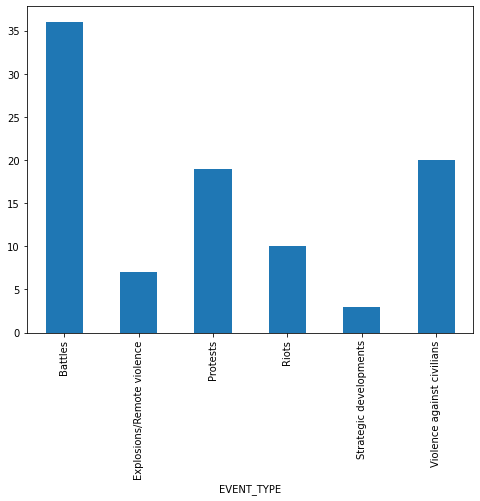

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
df_train.groupby('EVENT_TYPE')['NOTES'].count().plot.bar(ylim=0)
plt.show

Using tf-idf vector

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')

features = tfidf.fit_transform(df_train['NOTES'].apply(lambda x: np.str_(x))).toarray()
labels = df_train.category_id
features.shape

(100, 32)

In [ ]:
from sklearn.feature_selection import chi2
import numpy as np

N = 2
for event, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names_out())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("# '{}':".format(event))
  print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
  print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))

# 'Battles':
  . Most correlated unigrams:
. protest
. killed
  . Most correlated bigrams:
. people killed
. killed injured
# 'Explosions/Remote violence':
  . Most correlated unigrams:
. wounded
. militants
  . Most correlated bigrams:
. people killed
. killed wounded
# 'Protests':
  . Most correlated unigrams:
. killed
. protest
  . Most correlated bigrams:
. killed wounded
. people killed
# 'Riots':
  . Most correlated unigrams:
. people
. police
  . Most correlated bigrams:
. killed injured
. people killed
# 'Strategic developments':
  . Most correlated unigrams:
. nan
. military
  . Most correlated bigrams:
. killed wounded
. people killed
# 'Violence against civilians':
  . Most correlated unigrams:
. unidentified
. group
  . Most correlated bigrams:
. killed injured
. killed wounded


Now comes the training part
Let us benchmark on the following models:


*   Logistic Regression
*   (Multinomial) Naive Bayes
*   Linear Support Vector Machine
*   Randome Forest


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

X_train, X_test, y_train, y_test = train_test_split(df_train['NOTES'], df_train['EVENT_TYPE'], random_state = 0)

count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train.apply(lambda x: np.str_(x)))
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)



clf = MultinomialNB().fit(X_train_tfidf, y_train)

Lets make some predictions on this particular model to start with

In [ ]:
print(clf.predict(count_vect.transform(["insurgents attack a police station in kaaraan"])))

['Battles']


Moving on,

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  UserWarning,


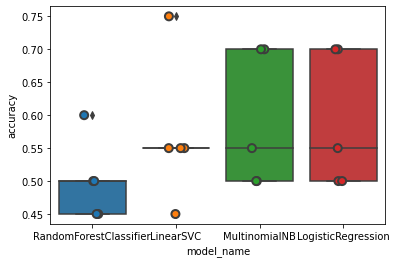

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

import seaborn as sns
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [ ]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.57
LogisticRegression        0.59
MultinomialNB             0.59
RandomForestClassifier    0.50
Name: accuracy, dtype: float64

Model Evaluation:

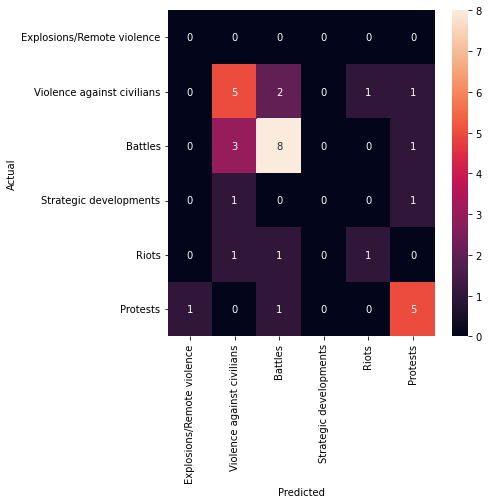

In [ ]:
model = LinearSVC()

X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df_train.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test+1, y_pred+1)
fig, ax = plt.subplots(figsize=(6,6))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=df_category_id.EVENT_TYPE.values, yticklabels=df_category_id.EVENT_TYPE.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In the above confusion matrix, majority of the predictions should end up on the diagonal(predicted label = actual label), where we want them to be.

Lets take a look at the misclassifications and we might find their causation.

In [ ]:
from IPython.display import display

for predicted in df_category_id.category_id:
  for actual in df_category_id.category_id:
    if predicted != actual and conf_mat[actual-1, predicted-1] >= 2:
      print("'{}' predicted as '{}' : {} examples.".format(id_to_category[actual], id_to_category[predicted], conf_mat[actual, predicted]))
      display(df_train.loc[indices_test[(y_test == actual) & (y_pred == predicted)]][['EVENT_TYPE', 'NOTES']])
      print('')

'Strategic developments' predicted as 'Battles' : 0 examples.


,EVENT_TYPE,NOTES



'Battles' predicted as 'Strategic developments' : 0 examples.


,EVENT_TYPE,NOTES
